In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [10]:
import arviz as az
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import bz2
import astropy.units as u
import h5py
import pickle
import pystan
from scipy.interpolate import interp1d
import seaborn as sns

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

In [3]:
samples = {}
with h5py.File('observations.h5', 'r') as f:
    for k in ['m1det', 'm2det', 'dl']:
        samples[k] = array(f['posteriors'][k])

In [4]:
sel = {}
with h5py.File('selected.h5', 'r') as f:
    sel['m1det'] = array(f['m1det'])
    sel['m2det'] = array(f['m2det'])
    sel['dldet'] = array(f['dl'])
    sel['wtdet'] = array(f['wt'])
    sel['N_gen'] = f.attrs['N_gen']

In [5]:
nobs = 64
nsamp = 32
nsel = 4096

ninterp = 500

zinterp = expm1(linspace(log(1), log(11), ninterp))

mnorm = exp(arange(log(1), log(200), 0.01))

data = {
    'nobs': nobs,
    'nsel': nsel,
    'ninterp': ninterp,
    'nnorm': len(mnorm),
    
    'nsamp': nsamp*ones(nobs, dtype=np.int),
    'nsamp_total': nsamp*nobs,
    
    'Tobs': 1.0/12.0*0.5,
    'N_gen': int(round(sel['N_gen']*nsel/float(len(sel['m1det'])))),
    
    'm1obs': samples['m1det'][:nobs, :nsamp].flatten(),
    'm2obs': samples['m2det'][:nobs, :nsamp].flatten(),
    'dlobs': samples['dl'][:nobs, :nsamp].flatten(),
    
    'm1sel': sel['m1det'][:nsel],
    'm2sel': sel['m2det'][:nsel],
    'dlsel': sel['dldet'][:nsel],
    'wtsel': sel['wtdet'][:nsel],
    
    'zinterp': zinterp,
    
    'ms_norm': mnorm,
    
    'use_cosmo_prior': 1,
    'mu_H0': Planck15.H0.to(u.km/u.s/u.Mpc).value,
    'sigma_H0': 0.01*Planck15.H0.to(u.km/u.s/u.Mpc).value,
    'mu_Omh2': 0.02225+0.1198,
    'sigma_Omh2': sqrt(0.00016**2 + 0.0015**2)
}

In [6]:
model = pystan.StanModel(file='model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4c7e3c602b5d53aba00011f37674377b NOW.
/Users/wfarr/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmpmua9xo35/stanfit4anon_model_4c7e3c602b5d53aba00011f37674377b_7134515759940519038.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [25]:
fit = model.sampling(data=data, iter=2000)

In [26]:
with bz2.BZ2File('test-run.pkl.bz2', 'w') as f:
    pickle.dump(model, f)
    pickle.dump(fit, f)

/Users/wfarr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
print(fit)

Inference for Stan model: anon_model_4c7e3c602b5d53aba00011f37674377b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
H0             67.73    0.01   0.66  66.41  67.29  67.73  68.18  69.05   2987    1.0
Om              0.31  1.3e-4 6.8e-3    0.3   0.31   0.31   0.31   0.32   2864    1.0
w              -1.11  6.5e-3    0.4  -1.85   -1.4  -1.12  -0.82   -0.3   3858    1.0
R0            110.62    0.72  37.67   55.3  84.55 105.38 129.36 201.09   2759    1.0
MMin            4.69    0.02   1.07    3.1   3.95   4.51   5.21   7.48   2652    1.0
MMax           42.46    0.09    3.9   33.6  40.13  42.94  45.18  49.19   1704    1.0
alpha           0.68  6.3e-3   0.39  -0.13   0.42   0.68   0.95   1.41   3773    1.0
beta            0.07  6.7e-3   0.47  -0.81  -0.26   0.06   0.37   1.04   4877    1.0
gamma            2.5    0.01   0.81   0.89   1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c25397128>,
      dtype=object)

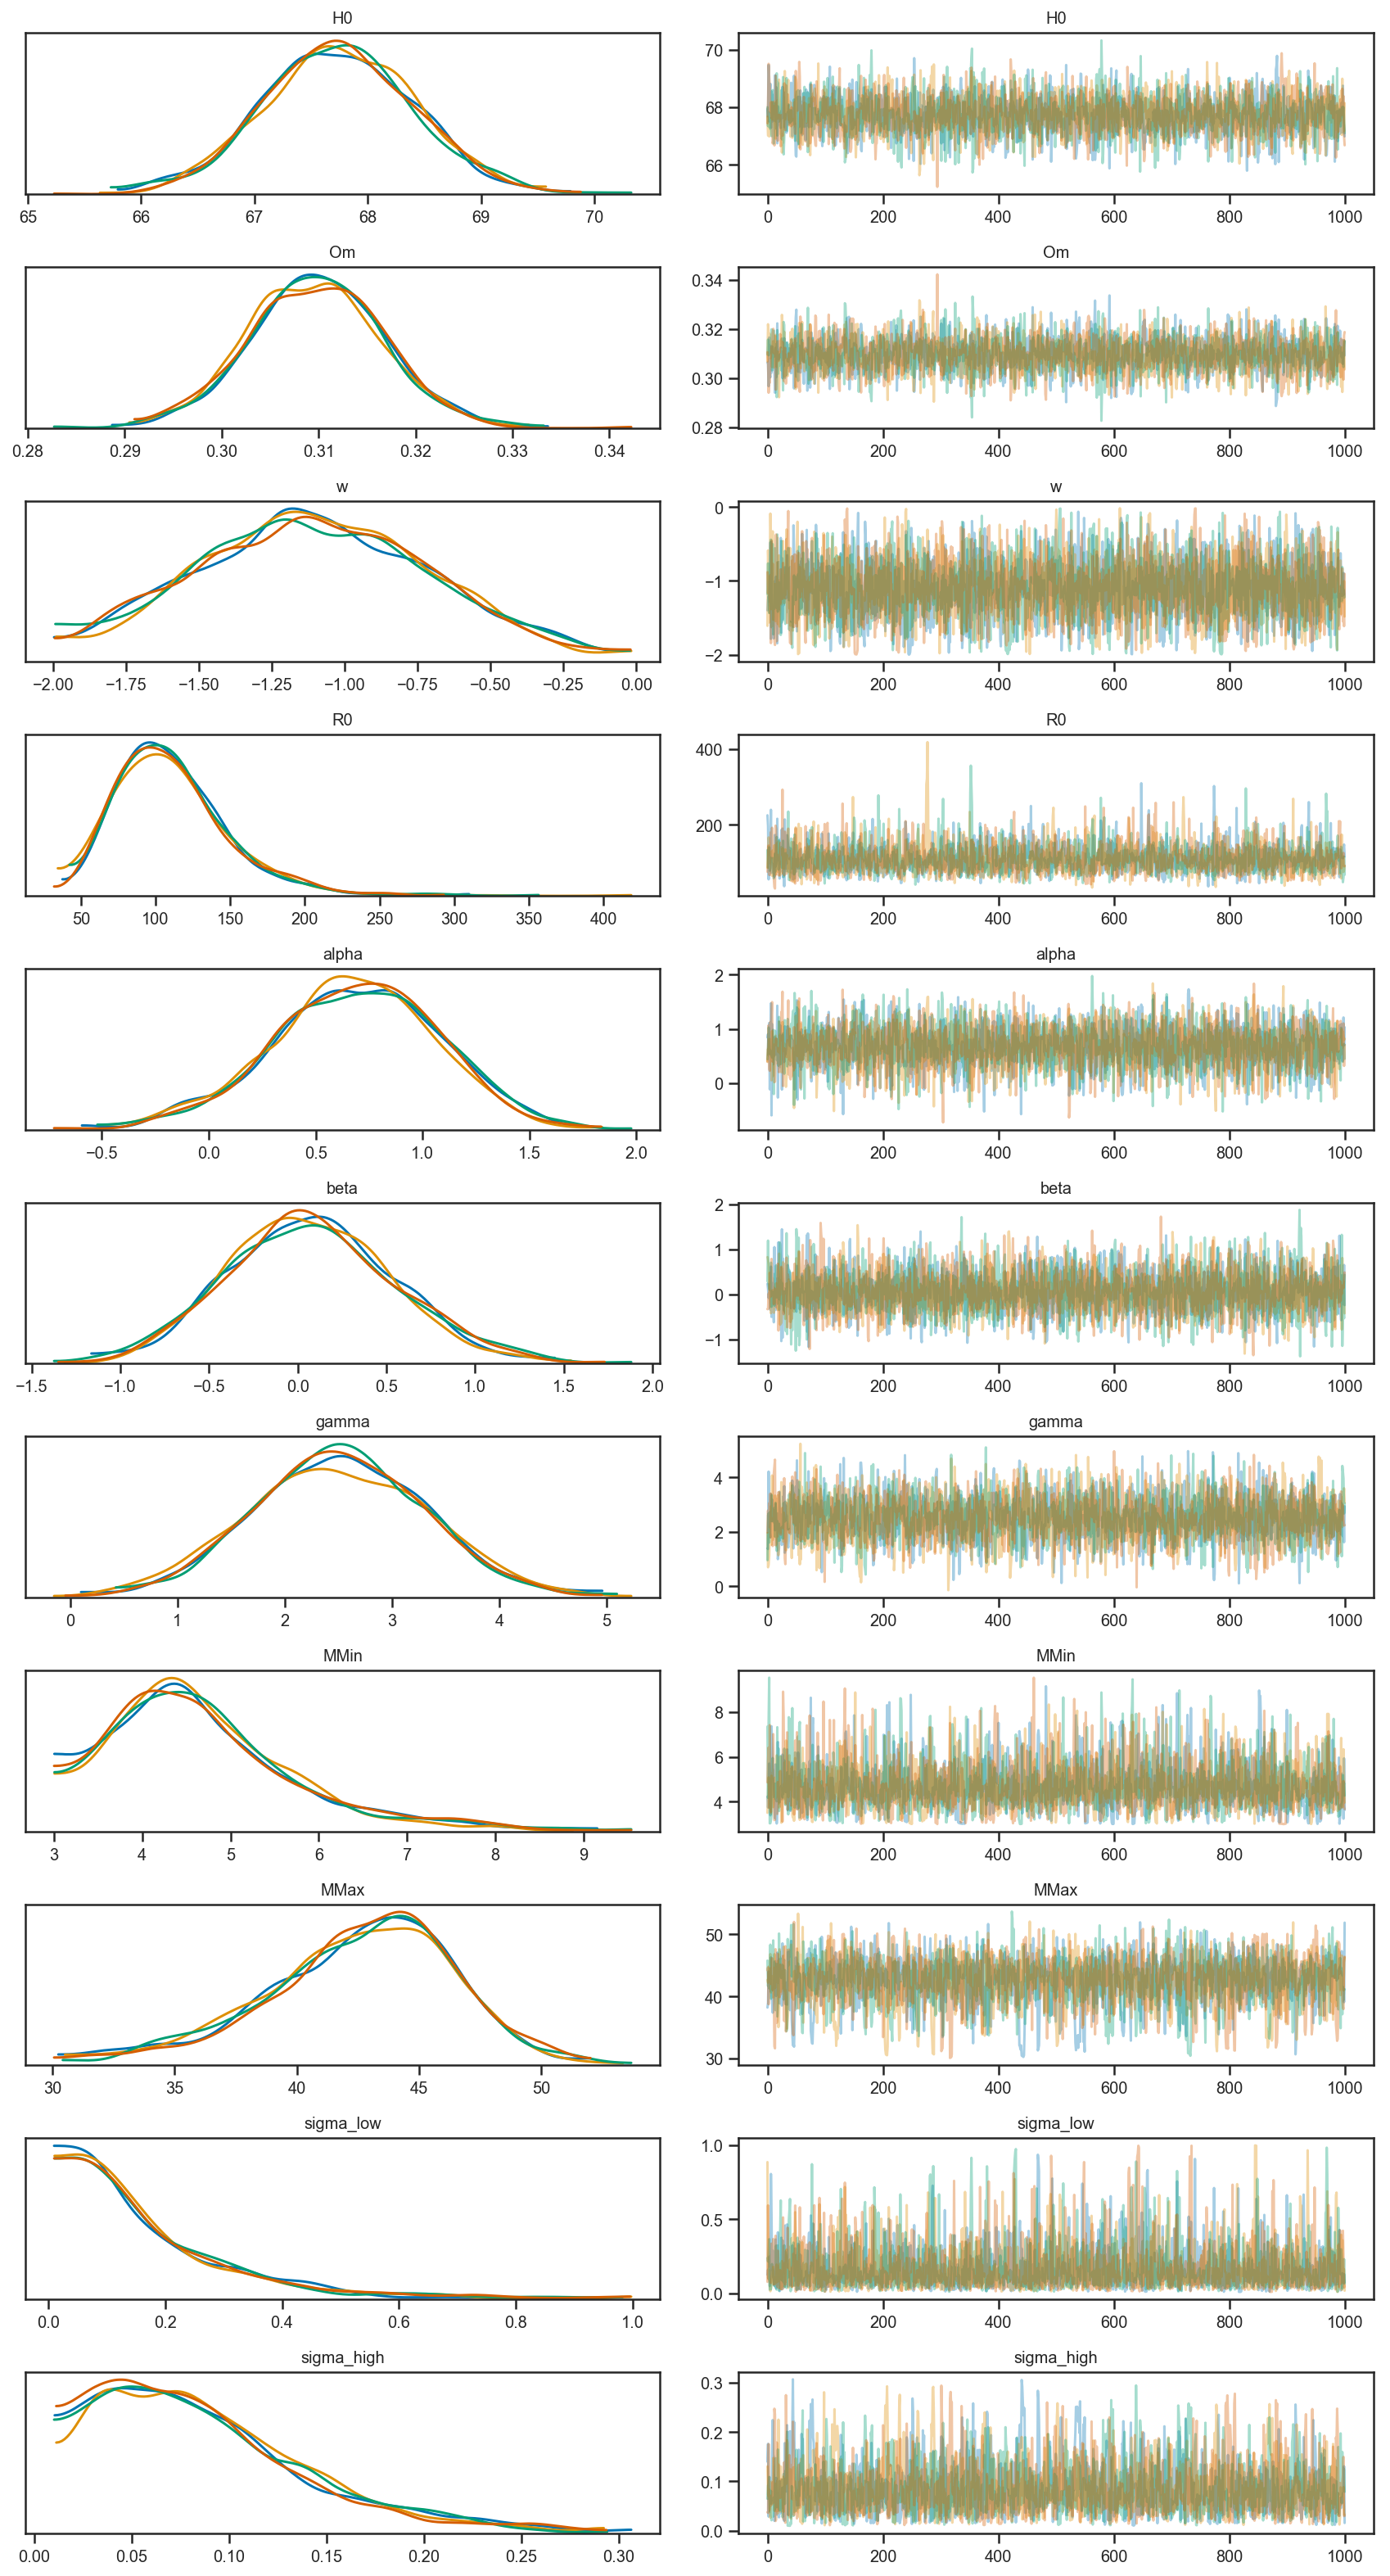

In [28]:
az.plot_trace(fit, var_names=['H0', 'Om', 'w', 'R0', 'alpha', 'beta', 'gamma', 'MMin', 'MMax', 'sigma_low', 'sigma_high'])

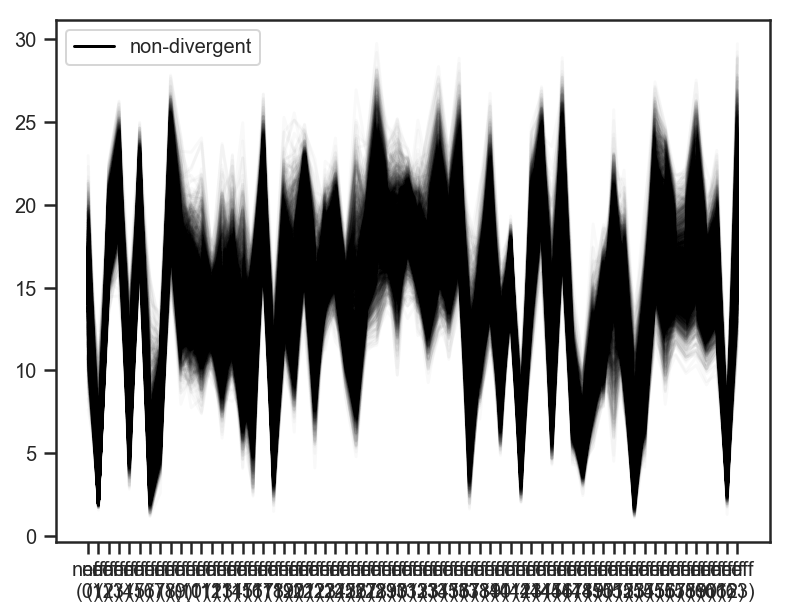

In [29]:
az.plot_parallel(fit, var_names=['neff'])